In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import random
import math
import pickle
from tqdm.notebook import tqdm_notebook
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
sys.path.append('../')
import fn
from addition_dataset import GroupAddition

In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preparation

In [61]:
def prepare_data(b, depth, table, batch_size=16, num_passes=1000, split=0.9):
    
    # Get indices of training and testing data
    N = b**depth
    ids = random.sample(range(N), math.ceil(split * N))
    heldout_ids = set(range(N)) - set(ids)
    
    # Create training dataset and dataloader
    training_dataset = GroupAddition(table, depth, ids=ids, interleaved=True, digit_order='reversed')
    training_dataset = torch.utils.data.ConcatDataset([training_dataset] * num_passes)
    training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    
    # Create testing dataset and dataloader
    testing_dataset = GroupAddition(table, depth, ids=heldout_ids, interleaved=True, digit_order='reversed')
    testing_dataset = torch.utils.data.ConcatDataset([testing_dataset] * num_passes)
    testing_dataloader = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=True)

    return training_dataloader, testing_dataloader

## Definitions

### Models and loss function

In [132]:
# Define model
class LSTMModel(nn.Module):
    '''Simple LSTM model for testing purposes'''
    def __init__(self, b, layers):
        super().__init__()
        self.b = b
        self.layers = layers
        self.lstm = nn.LSTM(b, b, layers, batch_first=True)
        self.linear = nn.Linear(b, 1)

    def forward(self, X):
        X_out, _ = self.lstm(X)
        X_out = self.linear(X_out).squeeze()
        return X_out

In [175]:
class PositionalEncoding(nn.Module):
    '''Positional encoder for transformer'''
    def __init__(self, b, max_len: int = 300):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, b, 2) * (-math.log(10000.0) / b))
        pe = torch.zeros(max_len, 1, b)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, X):
        X_out = X + self.pe[:X.size(0)]
        return X_out

In [176]:
# Define model
class TransformerModel(nn.Module):
    '''Simple transformer model for testing purposes'''
    def __init__(self, b, heads, layers):
        super().__init__()
        self.b = b
        self.heads = heads
        self.layers = layers
        self.pos_encoder = PositionalEncoding(b)
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(b, heads, batch_first=True), layers)
        self.linear = nn.Linear(b, 1)

    def forward(self, X):
        X_out = self.pos_encoder(X)
        X_out = self.transformer(X_out)
        X_out = self.linear(X_out).squeeze()
        return X_out

In [177]:
def prediction(X_out, ids):
    if X_out.dim() == 2:
        X_out_and_ids = zip(torch.unbind(X_out), torch.unbind(ids))
        s_out = torch.stack([X_out[ids] for X_out, ids in X_out_and_ids])
    else:
        s_out = X[ids]
    return s_out

In [178]:
class Loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X_out, s, ids):
        MSE = nn.MSELoss()
        s_out = prediction(X_out, ids)
        loss = MSE(s_out, s)
        return loss

### Training and testing loops

In [179]:
def train(model, training_dataloader, criterion, optimizer, print_losses=True):

    # Initialize variables
    losses = []
    t = 0

    # Training loop
    for batch_idx, (X, s, ids) in enumerate(training_dataloader):
        
        # Compute, store, and print loss
        loss = criterion(model(X), s.float(), ids)
        losses.append(loss.item())
        if print_losses and (t % 100 == 0):
            print(f't = {t}  loss = {loss.item():.6f}')
        
        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Iterate counter
        t += 1

    return losses

In [180]:
# Test model
def test(model, testing_dataloader, depth, batch_size, print_accuracy=True):
    
    with torch.no_grad():
        
        # Set model to evaluation mode
        model.eval()
    
        # Perform evaluation
        total_correct = 0
        total_samples = 0
        for batch_idx, (X, s, ids) in enumerate(testing_dataloader):
    
            # Forward pass
            X_out = model(X)
            s_out = prediction(X_out, ids)
            s_out = torch.round(s_out)
    
            # Calculate accuracy
            total_correct += ((s_out == s).sum(1) == depth).sum().item()
            total_samples += batch_size
    
        accuracy = total_correct / total_samples
        if print_accuracy:
            print(f'Accuracy on testing set: {accuracy:.4f}')

### Visualization

In [181]:
def smooth(losses, size=10):
    kernel = np.ones(size) / size
    smoothed_losses = np.convolve(losses, kernel, mode='same')
    return smoothed_losses

In [182]:
def plot_loss(all_losses, size=10):
    if len(all_losses) > 1:
        alpha = 0.5
    for c, losses in all_losses.items():
        plt.plot(smooth(losses, size=size), alpha=alpha, label=sorted(c)[0])
    if len(all_losses) > 1:
        plt.legend()
    plt.title(f'Epoch vs. Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.show()

In [183]:
def compute_table_losses(b, depth, batch_size, architecture):

    # Assert architecture is valid
    assert architecture in ['LSTM', 'transformer']
    
    # Get carry tables for base
    with open('../pickles/all_tables.pickle', 'rb') as f:
        all_tables = pickle.load(f)
    tables = all_tables[b]
    
    # Train model for each table
    all_losses = {}
    for c, table in tables.items():
    
        # Get dataloaders
        training_dataloader, testing_dataloader = prepare_data(b, depth, table, batch_size=batch_size)
        
        # Initialize model
        if architecture == 'LSTM':
            model = LSTMModel(b, 2)
        elif architecture == 'transformer':
            model = TransformerModel(b, 1)
        
        # Define criterion and optimizer
        criterion = Loss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
        # Train and test model
        losses = train(model, training_dataloader, criterion, optimizer, print_losses=False)
        print(c)
        test(model, testing_dataloader, depth, batch_size, print_accuracy=True)
        print()
        all_losses[c] = losses

    return all_losses

## Execute

### LSTM

In [80]:
all_losses = compute_table_losses(4, 3, 16, 'LSTM')

((0, 0, 3, 2), (0, 1, 1, 1), (0, 2, 3, 0), (0, 3, 1, 3))
Accuracy on testing set: 0.8633

((0, 0, 0, 0), (0, 1, 2, 3), (0, 2, 0, 2), (0, 3, 2, 1))
Accuracy on testing set: 1.0000



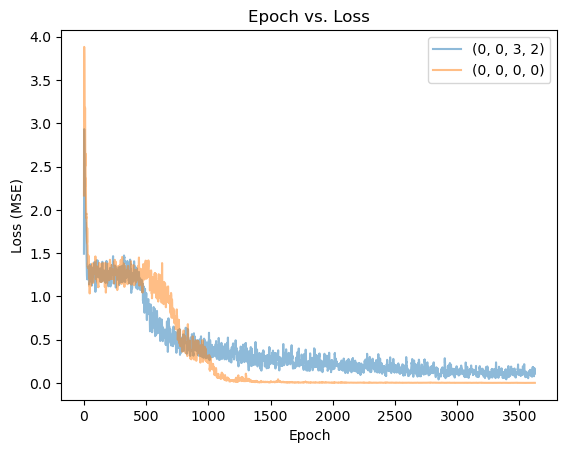

In [81]:
plot_loss(all_losses, size=4)

The LSTM does well with interleaved, reversed data (still need to check for harder formats). Able to achieve close to perfect accuracy on unseen tuples for all carry tables, seems like standard table loss converges more quickly than alternatives but want more robust data.

### Transformer

In [190]:
b = 4
depth = 2
batch_size = 16

In [191]:
# Get carry tables for base
with open('../pickles/all_tables.pickle', 'rb') as f:
    all_tables = pickle.load(f)
tables = all_tables[b]

In [192]:
table = tables[((0, 0, 0, 0), (0, 1, 2, 3), (0, 2, 0, 2), (0, 3, 2, 1))]

In [193]:
# Get dataloaders
training_dataloader, testing_dataloader = prepare_data(b, depth, table, batch_size=batch_size, num_passes=2000)

# Initialize model
model = TransformerModel(b, 2, 2)

# Define criterion and optimizer
criterion = Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [194]:
# Initialize variables
losses = []
t = 0

# Training loop
for batch_idx, (X, s, ids) in enumerate(training_dataloader):
    
    # Compute, store, and print loss
    loss = criterion(model(X), s.float(), ids)
    losses.append(loss.item())
    if (t % 100 == 0):
        print(f't = {t}  loss = {loss.item():.6f}')
    
    # Zero gradients, perform a backward pass, and update the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Iterate counter
    t += 1

t = 0  loss = 3.993464
t = 100  loss = 1.144009
t = 200  loss = 1.325825
t = 300  loss = 1.345300
t = 400  loss = 1.142428
t = 500  loss = 1.093876
t = 600  loss = 1.174075
t = 700  loss = 1.317793
t = 800  loss = 1.020974
t = 900  loss = 1.064950
t = 1000  loss = 1.374097
t = 1100  loss = 1.131702
t = 1200  loss = 1.146499
t = 1300  loss = 1.392166
t = 1400  loss = 1.459036
t = 1500  loss = 1.095876
t = 1600  loss = 1.381633
t = 1700  loss = 1.171405
t = 1800  loss = 1.313322


In [195]:
# Test model
test(model, testing_dataloader, depth, batch_size, print_accuracy=True)

Accuracy on testing set: 0.0000
